In [2]:
check_setup = False
if check_setup:
    
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
    import tensorflow as tf
    from keras import backend as K

    set_gpu=True

    if set_gpu:
        os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
        os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
        print(os.environ["CUDA_VISIBLE_DEVICES"])


        num_cores = 39

        GPU=True
        CPU=False

        if GPU:
            num_GPU = 1
            num_CPU = 1
        if CPU:
            num_CPU = 1
            num_GPU = 0

        config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                inter_op_parallelism_threads=num_cores, 
                                allow_soft_placement=True,
                                device_count = {'CPU' : num_CPU,
                                                'GPU' : num_GPU}
                               )

        session = tf.Session(config=config)
        K.set_session(session)


In [3]:
#!wget https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv

In [ ]:
#!pip install pyforest
#from pyforest import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras

# Data Loading and Processing

In [82]:
df = pd.read_csv("../data/df_final_processed.csv", index_col = 0)
df.head()

,datetime,level,rain,vel_wind,dir_wind,level_std,level_scaled,dist,dist_std,dist_scaled,ts,inv_dist,inv_dist_std,inv_dist_scaled,inv_dist_2,inv_dist_2_std,inv_dist_2_scaled,dummy_rain,vel_wind_kmh,vel_wind_dummy
0,2010-01-01 00:00:00,102.0,0.0,0.2,337.5,2.461852,0.763636,353510.208614,-2.034933,0.043682,1262304000000000000,0.000003,2.156252,0.949046,8.001955e-12,2.219529,0.945147,0,0.72,0
1,2010-01-01 01:00:00,100.0,0.0,0.7,315.0,2.389875,0.754545,353731.458075,-2.020637,0.047277,1262307600000000000,0.000003,2.139458,0.944887,7.991948e-12,2.201361,0.940688,0,2.52,0
2,2010-01-01 02:00:00,86.0,0.0,1.5,247.5,1.886035,0.690909,354197.433405,-1.990529,0.054849,1262311200000000000,0.000003,2.104155,0.936144,7.970933e-12,2.163208,0.931324,0,5.40,0
3,2010-01-01 03:00:00,74.0,0.0,1.3,247.5,1.454172,0.636364,354875.253700,-1.946732,0.065863,1262314800000000000,0.000003,2.052969,0.923467,7.940513e-12,2.107977,0.917768,0,4.68,0
4,2010-01-01 04:00:00,65.0,0.0,1.3,247.5,1.130275,0.595455,355718.662776,-1.892236,0.079569,1262318400000000000,0.000003,1.989551,0.907761,7.902904e-12,2.039695,0.901010,0,4.68,0


Scaling the series in a (0.01, 1) range for the lstm treatment, being careful not to generate problems with mape evaluation.

In [83]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0.01, 1))

series = sc.fit_transform(df.level.values.reshape(-1, 1))
series.shape

(78888, 1)

Creating the n-hour shifted series (using np.roll plus padding in order to be able to easy combine with the keras built in TimeseriesGenerator

In particular, this notebook demonstrate the procedure for predicting a single 24h ahead step.

For the 1h ahead step, the procedure is even less complicated (no need to create the shifted target series with padding and rolling the original series,)

For the 168h ahead step, the procedure is identical with a different roll shift and slightly different splittings in the generator steps

In [85]:
# 24h ahead single preds
padded_series = np.expand_dims(np.concatenate([series.flatten(), np.zeros(23)]), axis = -1)
padded_series

target_series = np.roll(padded_series, -23)[:series.shape[0]] #need to discard the last as well

target_series = target_series[:-23]  #removing the zero padding
series = series[:-23] #removing the zero padding

series.shape, target_series.shape

((78842, 1), (78842, 1))

Splitting the time series into 3 disjoint but subsequential sets:
 - the train set 
 - the validation set (the week before the last week)
 - the test set (the last week)
 
the training is validated with the validation set, in such a way not to exploit informations relative to the final test set (treated as unknown).

In [141]:
split_index = -7*24 #one week split

train_generator = TimeseriesGenerator(series, target_series, start_index=0, end_index=len(series) + 2*split_index-1, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(series, target_series, start_index=len(series) + 2*split_index-n_input, end_index=len(series)+split_index-1, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(series, target_series, start_index=len(series) + split_index -n_input, end_index=len(series)-1, length=n_input, batch_size=1)

Demonstrating the non-overlapping splits

In [143]:
for it, (train, test) in enumerate(train_generator):
    #print(it)
    if it == len(train_generator)-1:
        print(it)
        print(train, test)
for train, test in val_generator:
    print(train, test)
    break

78481
[[[0.4735]
  [0.505 ]
  [0.541 ]
  [0.5725]
  [0.5815]
  [0.5725]
  [0.55  ]
  [0.514 ]
  [0.4735]
  [0.4465]
  [0.4375]
  [0.442 ]
  [0.4645]
  [0.4735]
  [0.4735]
  [0.46  ]
  [0.4375]
  [0.406 ]
  [0.388 ]
  [0.37  ]
  [0.361 ]
  [0.3475]
  [0.3565]
  [0.37  ]]] [[0.3925]]
[[[0.505 ]
  [0.541 ]
  [0.5725]
  [0.5815]
  [0.5725]
  [0.55  ]
  [0.514 ]
  [0.4735]
  [0.4465]
  [0.4375]
  [0.442 ]
  [0.4645]
  [0.4735]
  [0.4735]
  [0.46  ]
  [0.4375]
  [0.406 ]
  [0.388 ]
  [0.37  ]
  [0.361 ]
  [0.3475]
  [0.3565]
  [0.37  ]
  [0.4015]]] [[0.424]]


In [144]:
for it, (train, test) in enumerate(val_generator):
    #print(it)
    if it == len(val_generator)-1:
        print(it)
        print(train, test)
for train, test in test_generator:
    print(train, test)
    break

167
[[[0.496 ]
  [0.4465]
  [0.4105]
  [0.4105]
  [0.4465]
  [0.5095]
  [0.5725]
  [0.631 ]
  [0.6715]
  [0.6715]
  [0.6355]
  [0.55  ]
  [0.4555]
  [0.352 ]
  [0.253 ]
  [0.181 ]
  [0.1495]
  [0.19  ]
  [0.2845]
  [0.3925]
  [0.4825]
  [0.5545]
  [0.5995]
  [0.5995]]] [[0.5905]]
[[[0.4465]
  [0.4105]
  [0.4105]
  [0.4465]
  [0.5095]
  [0.5725]
  [0.631 ]
  [0.6715]
  [0.6715]
  [0.6355]
  [0.55  ]
  [0.4555]
  [0.352 ]
  [0.253 ]
  [0.181 ]
  [0.1495]
  [0.19  ]
  [0.2845]
  [0.3925]
  [0.4825]
  [0.5545]
  [0.5995]
  [0.5995]
  [0.559 ]]] [[0.586]]


In [145]:
len(train_generator), len(val_generator), len(test_generator)

(78482, 168, 168)

However, the generator approach (i.e. using fit_generator, predict_generator and so on) with a multigpu model seems very slow, thus we transfor the generator batches into a whole batch dataset for the train, val and test phases.

In [93]:
train_list = []
test_list = []
for train,test in train_generator:
    train_list.append(train)
    test_list.append(test)
train_input = np.concatenate(train_list, axis = 0)
train_targets = np.concatenate(test_list, axis = 0)
train_input.shape, train_targets.shape

((78483, 24, 1), (78483, 1))

In [97]:
train_list = []
test_list = []
for train,test in val_generator:
    train_list.append(train)
    test_list.append(test)
val_input = np.concatenate(train_list, axis = 0)
val_targets = np.concatenate(test_list, axis = 0)
val_input.shape, val_targets.shape

((168, 24, 1), (168, 1))

In [146]:
train_list = []
test_list = []
for train, test in test_generator: #some weird but with the last access
    train_list.append(train)
    test_list.append(test)

    
test_input = np.concatenate(train_list, axis = 0)
test_targets = np.concatenate(test_list, axis = 0)
test_input.shape, test_targets.shape

((168, 24, 1), (168, 1))

# The Model

Many attempts were made, in order to define a deep learning model suitable for the task.

LSTM seems to outperform the others (RNN, GRUs), even though the GRU model had quite similar performances.

In [91]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, CuDNNLSTM, LeakyReLU, Dropout, BatchNormalization
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.optimizers import Adam 

n_features = 1

# define model
def make_model(n_input, n_features, 
               verbose = False, multi = True, use_CuDNNLSTM = True,
              loss = "mse", metrics = ["mae", "mape"],
              lr = 0.001):
    K.clear_session()
    LSTM_layer = LSTM if not use_CuDNNLSTM else CuDNNLSTM
    opt = Adam (lr = lr )
    
    model = Sequential()
    
    model.add(LSTM_layer(512, input_shape=(n_input, n_features), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.3))
    for i in range(0):
        model.add(LSTM_layer(512, return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout( rate = 0.4))
    
    for i in range(1):
        model.add(LSTM_layer(256, return_sequences = False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(rate = 0.3))

    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.2))
    
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss=loss, metrics = metrics)
    if verbose:
        model.summary()
    if multi:
        mmodel = multi_gpu_model(model, 2)
        mmodel.compile(optimizer=opt, loss=loss, metrics = metrics)
        return mmodel, model
    else: 
        
        return None, model

Initializing the wandb callback for a nice experiment tracking

In [100]:
import wandb
wandb.login()


True

Many attempts were made, exploring different input configurations (which lags to get as input).
The training plots of some of those attempts are visible in the wandb repository linked in the cell below.

In [110]:
from wandb.keras import WandbCallback as wb

wandb.init(project = "venice_is_drowing", name = "lstm_single_output_test_24h")
cfg = wandb.config
#lookback size
n_input = 1*24
batch_size = 256
cfg.batch_size = batch_size
cfg.n_features = n_features
cfg.n_input = n_input
cfg.epochs = 150

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Defining the model, using a univariate input (the lagged time series itself), and the CUDA implementation of the LSTM node, which is much faster particularly with a multi-gpu support

In [114]:
mmodel, model = make_model(n_input, n_features, lr = 0.001,
                           multi = True, use_CuDNNLSTM = True, verbose = True,
                           loss = "mse", metrics = ["mae", "mape"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 24, 512)           1054720   
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 512)           2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 512)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 512)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               788480    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

Early Stopping and a Learning Rate Scheduler are implemented in order not to overfit the model onto the training set.

As a choice of not-overfitting the validation set (upon which the Early stopping is monitoring) the weights are not restored after the early stopping.

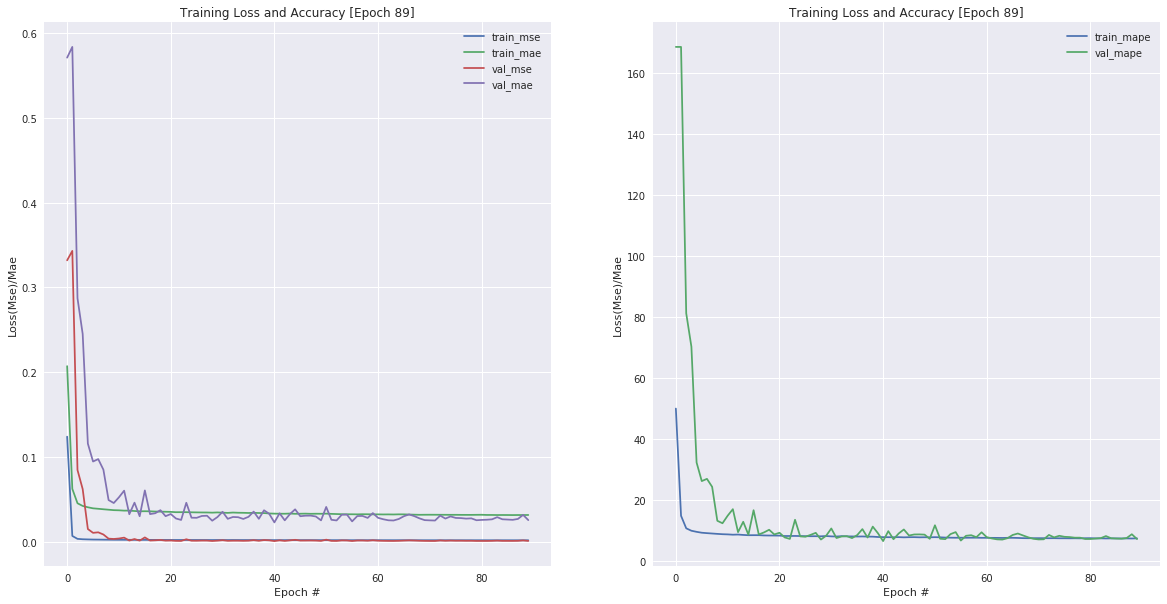

Epoch 91/150
78695/78695 [==============================] - 16s 205us/step - loss: 0.0019 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 7.5567 - val_loss: 0.0013 - val_mean_absolute_error: 0.0281 - val_mean_absolute_percentage_error: 8.0759
Restoring model weights from the end of the best epoch
Epoch 00091: early stopping


In [115]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from myutils import TrainingPlot


plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = False, verbose = 1)
rl = ReduceLROnPlateau(monitor = "val_loss", patience = 10, cooldown=5, factor=0.5, verbose = 1)

# fit model
history = mmodel.fit(
    train_input, train_targets,
    epochs=cfg.epochs,
    batch_size = cfg.batch_size,
    
    verbose=1, 
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (val_input, val_targets),
    
    callbacks=[plot_losses, 
              es, rl,
              wb(log_gradients=False, log_weights=False)
              ]
)

In [116]:
#model.save("lstm_mape_single_24_step_ahead_y_10_18.h5")

In [12]:
#from keras.models import load_model
#model = load_model("lstm_mape_single_24_step_ahead_y_10_18.h5")

# Predictions and Evaluations

Two different kind of predictions are made for each n-h ahead step:

- one shot predictions (the model predicts only 1 step ahead (n-hours, in this case 24h))

- iterated predictions based real data (the  model takes as input real data from the test set)

- iterated predictions based on previously made predictions (the  model takes as input the previously predicted points)

the iterated predictions are averaged over the whole week of the final test set



In keras, It is straightforward to get one shots predictions and iterated predictions over the real data 

In [150]:
real_preds1 = model.predict(test_input).flatten() #iterated predictions on real data

real_preds1[0] #one_shot prediction on the first step in the test set


0.58040655

Regarding the iterated predictions on the predicted data, one need a custom function to iterated over the test set.

First (i<24) we predict the first 24 points of the test set using the real data of the validation set, then we iterate the predictions on those already-predicted data

In [151]:
def iterate_prediction(input_seq = series[-n_input+split_index:split_index], pred_len = 168):
    init_test_arr = np.expand_dims(input_seq, axis = 0)
    #init_test_arr = np.concatenate((init_test_arr, np.zero_like(init_test_arr))
    preds = []
    for i in range(pred_len):
        if i < 24: #evaluate on real data for 
            pred = model.predict(test_input[i:i+1], )[0][0]
            preds.append(pred)
        else:
            test_features = np.squeeze(np.squeeze(init_test_arr, axis = -1), axis = 0).tolist()
            pred = model.predict(init_test_arr)[0][0]
            preds.append(pred)
            test_features.append(pred)
            init_test_arr = np.atleast_3d(test_features[-n_input:])

    return np.array(preds)

preds1 = iterate_prediction()

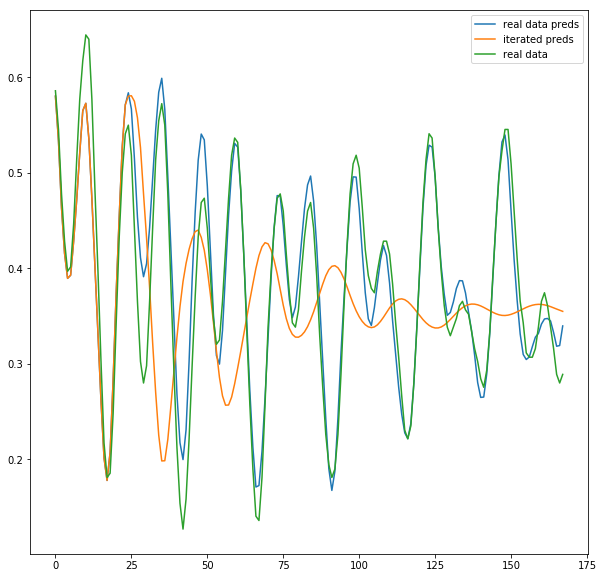

In [183]:
#real_data = series[split_index:].flatten()
real_data = test_targets.flatten()
def plot_preds(real_preds, real_data, preds):
    plt.figure(figsize=(10,10))
    plt.plot(real_preds, label = "real data preds")
    plt.plot(preds, label = "iterated preds")
    plt.plot(real_data, label = "real data")
    plt.legend()
    plt.show()

plot_preds(real_preds1, real_data, preds1)

In [148]:
# utility for calculating mape and rmse

In [161]:
real_preds1.shape, preds1.shape

((168,), (168,))

# Evaluations:

- RMSE

In [181]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rmse_real_preds = sqrt(mean_squared_error(sc.inverse_transform(real_preds1.reshape(-1, 1)), sc.inverse_transform(real_data.reshape(-1, 1))))
rmse_preds = sqrt(mean_squared_error(sc.inverse_transform(preds1.reshape(-1, 1)), sc.inverse_transform(real_data.reshape(-1, 1))))
rmse_single_pred = sqrt(mean_squared_error(sc.inverse_transform(real_data[0:1].reshape(-1, 1)), sc.inverse_transform(preds1[0:1].reshape(-1, 1))))

rmse_real_preds, rmse_preds, rmse_single_pred

(8.322509894099385, 19.163658623481385, 1.2430191040039062)

- mape

In [182]:
def calc_mape(real, pred):
    return (100*np.abs(real-pred)/real/real.shape[0]).sum()
print(calc_mape(real_data, real_preds1)) #mape on real-data preds
print(calc_mape(real_data, preds1)) #mape on iterated preds
print(calc_mape(real_data[0:1], preds1[0:1]))

6.104819368559127
20.721032408874194
0.9545345762076987
